# Import, preprocess and align offshore swell observations with surf height observations

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

## Read surf height observations
Import surf height observations and convert ymd to a date index

In [2]:
obs_dat = pd.read_table("./data/oahu_all.dat", delim_whitespace=True, names=["year", "month", "day", "nshor", "wshor", "almo", "dh", "winw", "wspd", "wdir", "nsd", "ssd"])
obs_dat['date'] = pd.to_datetime(obs_dat.year*10000+obs_dat.month*100+obs_dat.day,format='%Y%m%d')
obs_dat = obs_dat.set_index("date")
print (obs_dat.head)
print( obs_dat.shape)

<bound method NDFrame.head of             year  month  day  nshor  wshor  almo  dh  winw  wspd  wdir  nsd  \
date                                                                          
2010-01-01  2010      1    1      6      4     2   3     4     3     2   16   
2010-01-02  2010      1    2      7      4     2   2     3     2    17   14   
2010-01-03  2010      1    3      6      4     2   2     2     4    11   15   
2010-01-04  2010      1    4      6      3     2   2     2     4    11   14   
2010-01-05  2010      1    5     18      6     2   2     2     4    11   14   
...          ...    ...  ...    ...    ...   ...  ..   ...   ...   ...  ...   
2016-12-27  2016     12   27      4      2     1   2     4     6     5   15   
2016-12-28  2016     12   28      3      1     1   2     3     5     3   15   
2016-12-29  2016     12   29     10      2     1   1     6     4     3   16   
2016-12-30  2016     12   30      6      2     1   1     5     5     2    2   
2016-12-31  2016     1

## Import buoy data / offshore observation
Import data from the offshore sensor.

- Shift GMT into Hawaiian local time
- Remove data before and after sunset (When we presume observation would be impossible)
- Filter data to give only rows with maximum daily WVHT

In [3]:
# Read all years and concatenate
all_dat = []
for year in range(2010, 2017):
    dat = pd.read_table("./data/buoy_"+str(year)+".dat", delim_whitespace=True, skiprows=3, names=["YYYY", "MM", "DD", "hh", "mm", "WDIR", "WSPD", "GST",  "WVHT", "DPD", "APD", "MWD", "PRES", "ATMP", "WTMP", "DEWP",  "VIS", "TIDE"])
    all_dat.append(dat)
dat = pd.concat(all_dat)

# Convert the date columns into a datetime index
dat['date'] = pd.to_datetime(dat.YYYY.astype(str)+"-"+dat.MM.astype(str)+"-"+dat.DD.astype(str)+" "+dat.hh.astype(str)+":"+dat.mm.astype(str)+":00")
dat = dat.set_index(pd.DatetimeIndex(dat['date']))

# The buoy data is reported in GMT but the observations are in Hawaiian time. Given the observations are 'maximum'
# value in day we don't have to be too precise here (eg. worry about DST) but we do need to shift this data.
dat.index = dat.index + timedelta(hours=-10)

# We know (or assume!) observations are taken during daylight hours. Again with the imprecision inherent in the 
# observation data we probably don't gain by over thinking this but here's a filter:
hour = dat.index.hour
selector = ((hour >= 7) & (hour <= 17))
dat= dat[selector]

# We know the observations are for the daily largest heights. Here we'll filter our buoy data to just the daily
# row with the largest WVHT value. This presumes WVHT is a correlate with our observed heights and that assumption
# will predjudice our model outcomes. Feel free to use a different method!
idx = dat.groupby(
            ([dat.index.year, dat.index.month, dat.index.day])
            )['WVHT'].transform(max) == dat['WVHT']

dat = dat[idx]

idx = dat.resample('d').max()

buoy_dat = idx

buoy_dat = buoy_dat.replace(99.0, np.nan)

print (buoy_dat.head)
print (buoy_dat.shape)

<bound method NDFrame.head of               YYYY    MM    DD    hh    mm   WDIR  WSPD  GST  WVHT    DPD  \
date                                                                        
2009-12-31  2010.0   1.0   1.0   1.0  51.0  999.0   NaN  NaN  2.83  13.33   
2010-01-01  2010.0   1.0   1.0  18.0  51.0  999.0   NaN  NaN  2.28  11.11   
2010-01-02  2010.0   1.0   3.0  23.0  51.0  999.0   NaN  NaN  1.96  16.67   
2010-01-03  2010.0   1.0   3.0  18.0  51.0  999.0   NaN  NaN  1.84  14.29   
2010-01-04  2010.0   1.0   4.0  17.0  51.0  999.0   NaN  NaN  2.15  11.11   
...            ...   ...   ...   ...   ...    ...   ...  ...   ...    ...   
2016-12-27  2016.0  12.0  27.0  17.0  32.0  999.0   NaN  NaN  2.24  11.76   
2016-12-28  2016.0  12.0  28.0  17.0   2.0  999.0   NaN  NaN  1.99  13.33   
2016-12-29  2016.0  12.0  30.0   3.0   2.0  999.0   NaN  NaN  4.21  11.76   
2016-12-30  2016.0  12.0  30.0  17.0   2.0  999.0   NaN  NaN  3.64  10.53   
2016-12-31  2016.0  12.0  31.0  18.0  32.0  99

## Merge our date sets on date
Merge such that each row now represents the human observed surf heights for that day with the largest sensor observed offshore wave heights and all corresponding sensor data

In [5]:
all_dat = pd.merge(buoy_dat,obs_dat, how='outer', left_index=True, right_index=True)
print (all_dat.shape)
print (all_dat.iloc[200:400]['WVHT'])
print (all_dat.iloc[200:400]['nshor'])

(2560, 31)
date
2010-07-19    1.89
2010-07-20    1.58
2010-07-21    1.36
2010-07-22    1.38
2010-07-23    1.19
              ... 
2011-01-29    2.33
2011-01-30    1.86
2011-01-31    5.04
2011-02-01    3.31
2011-02-02    2.19
Name: WVHT, Length: 200, dtype: float64
date
2010-07-19     3.0
2010-07-20     3.0
2010-07-21     2.0
2010-07-22     2.0
2010-07-23     1.0
              ... 
2011-01-29     8.0
2011-01-30     7.0
2011-01-31    20.0
2011-02-01    15.0
2011-02-02     8.0
Name: nshor, Length: 200, dtype: float64


## Visualize / Check the data
Plotting timeseries from both WVHT and nshore shows some correlation - enough to suggest we're on the right track
but with more than enough variance to suggest that a successful model might want to investigate other features eg DPD

/Users/stephenscherrer/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


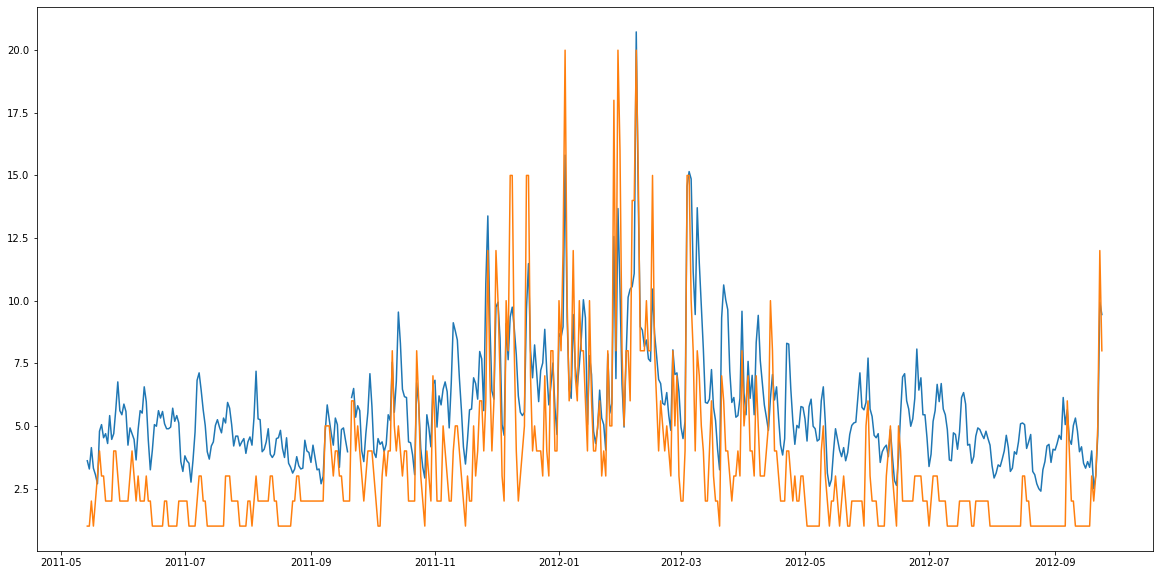

In [6]:
plt.figure(figsize=(20,10))

test_WVHT = all_dat['WVHT'][500:1000] * 3.28 # NB Converted Meters to Feet
test_nshor = all_dat['nshor'][500:1000]
plt.plot(test_WVHT) # Convert meters to feet
plt.plot(test_nshor) # Observations are half actual face height

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(test_WVHT, test_nshor)

In [8]:
all_dat.to_csv("./data/preprocessed_all.csv", index = False)

Index(['YYYY', 'MM', 'DD', 'hh', 'mm', 'WDIR', 'WSPD', 'GST', 'WVHT', 'DPD',
       'APD', 'MWD', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'VIS', 'TIDE', 'date',
       'year', 'month', 'day', 'nshor', 'wshor', 'almo', 'dh', 'winw', 'wspd',
       'wdir', 'nsd', 'ssd'],
      dtype='object')